# ANN Training and Validation

This exercise is split into two different parts, first you will be implementing and training a 2-layer neural network using a high level library, [pytorch](https://pytorch.org/). Secondly you will implement the neural network, the forward pass and the backward pass from scratch using numpy. The data which will be used is a subset of the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset which contains handwritten numbers from 0-9. Examples can be seen in the image below.

![MNIST digits](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

## Literature
Before starting with the implementation you should familiarize yourself with relevant sections from the [deep learning book](https://www.deeplearningbook.org/). This will help you understand the theory behind neural networks and what mathematical formulas are important for the task. The lectures has touched on most of these concepts too. Below you can find a list of recommended sections from the book. If you feel that you are already familiar with the contents of the section, feel free to skip it.

* Chapter 5 - Machine learning basics
    - Section 5.1 - Explains the basics of what we mean by learning and what supervised learning is.
    - Section 5.2 - Talks about generalization, the generalization gap and under/overfitting.
    - Section 5.3 - Validation and validation set.
* Chapter 6 - Deep feedforward networks
    - Section 6.0 - Discusses what do we mean by feedfoward networks and terminology such as input layer, output layer and hidden layer.
    - Section 6.2 - Discusses what gradient based learning is and what cost functions are.
    - Section 6.5 - Explains back-propagation. Important here are the formulas 6.49 - 6.52.
    
## Examination

### Part 1
* Implementation of a 2 layer NN (very similar to ex0)
* Training of this 2 layer NN (once again, very similar to ex0)
* Validation of the network during training
    - Save the model which performs the best on the validation data
* Graph the training loss vs validation loss
* At least 85% accuracy on the validation data (remember to load the best performing model before performing the accuracy test)

### Part 2
* Implementation of a 2 layer NN using numpy
* Training and validation of the 2 layer NN
    - Once again, save the best performing model (can be done in memory)
* Graph the training vs validation loss
* At least 50% accuracy on the validation data (can be hard to get high accuracy)

# Part 1

## MNIST dataset preparation
We will start by downloading and preparing the data such that it is usable for our purposes.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy
import copy

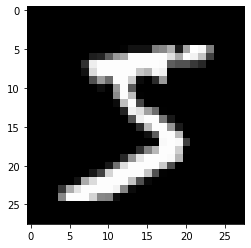

In [2]:
# Define the mini-batch size
batch_size = 1000

# Define how many epochs we want the training to be
epochs = 15

# Download the dataset and create the dataloaders
mnist_train = datasets.MNIST("./", train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False)

mnist_validation = datasets.MNIST("./", train=False, download=True, transform=transforms.ToTensor())
validation_loader = DataLoader(mnist_validation, batch_size=batch_size, shuffle=False)

def plot_digit(data):
    data = data.view(28, 28)
    plt.imshow(data, cmap="gray")
    plt.show()

images, labels = next(iter(train_loader))
plot_digit(images[0])

## Implement a classifier using pytorch

Given the code above, your knowledge from the literature, lectures and exercise 0. Implement a 2 layer neural network using pytorch. This network should be capable of being trained and validated. The weights of the model which performs the best on the validation data should be stored to make it easy to use them. You are free to choose any optimizer and loss function. Just note that some loss functions require the labels to be 1 hot encoded. **As you will not use convolutional layers (later in the course), the input needs to be changed to a 1d tensor (see [view](https://pytorch.org/docs/stable/tensors.html?highlight=view#torch.Tensor.view)).**

Epoch 15 [60/60] - Loss: 0.026741662994027138
Percentage correct: 93.0% (93 / 100)


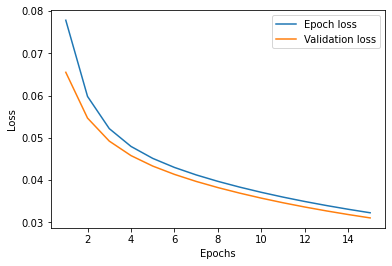

In [19]:
# Create two lists of losses to graph later
losses_epoch = []
losses_validation = []

bestloss = 1000000
bestnetwork = 0

def predict_on_images(iterator, images_to_show):
    global bestnetwork
    numberOfCorrect = 0
    images, labels = next(iterator)
    for index in range(images_to_show):
        #plot_digit(images[0])

        input_tensor = images[index].view(1,784)
        prediction = bestnetwork(input_tensor)
        guess = torch.argmax(prediction[0], dim=-1)
        #print(f'Prediction: {guess.item()} - Actual: {labels[index].item()}')
        if (guess.item() == labels[index].item()):
            numberOfCorrect +=1
    print(f'\nPercentage correct: {(numberOfCorrect/images_to_show)*100}% ({numberOfCorrect} / {images_to_show})') #Print ratio of correct predictions
    
def predict_on_validation():
    global bestloss
    global bestnetwork
    totalloss = 0
    for batch_nr, (images, labels) in enumerate(validation_loader):
        labels = to_onehot(labels)
        images = images.view(-1,784)
        prediction = network(images)
        loss = loss_function(prediction, labels)         
        totalloss += loss.item()
    losses_validation.append(totalloss/len(validation_loader))
    if totalloss < bestloss:
        bestnetwork = copy.deepcopy(network)

network = nn.Sequential(
    nn.Linear(784, 100), 
    nn.ReLU(),
    nn.Linear(100, 10) 
)

lr=0.1

optimizer = optim.SGD(network.parameters(), lr)

loss_function = nn.MSELoss()

to_onehot = nn.Embedding(10, 10) 
to_onehot.weight.data = torch.eye(10)

epochs = 15

for epoch in range(epochs):
    
    batchloss = 0
    for batch_nr, (images, labels) in enumerate(train_loader):
        
        labels = to_onehot(labels)
        
        images = images.view(-1,784)
        
        prediction = network(images)
        
        loss = loss_function(prediction, labels)
        
        loss.backward()
        
        optimizer.step()
        
        optimizer.zero_grad()
        
        # Store loss to total
        batchloss += loss.item()
        
        print(
            '\rEpoch {} [{}/{}] - Loss: {}'.format(
                epoch+1, batch_nr+1, len(train_loader), loss
            ),
            end=''
        )
    # Get average loss for this epoch using batch size
    losses_epoch.append(batchloss/len(train_loader))
    predict_on_validation()
        
# Have the trained network predict on the validation loader
predict_on_images(iterator = iter(validation_loader), images_to_show = 100)

epline, = plt.plot(range(1,epochs+1),losses_epoch)
valine, = plt.plot(range(1,epochs+1),losses_validation)
epline.set_label('Epoch loss')
plt.legend()
valine.set_label('Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Part 2

## Implement a classifier using numpy
Implement a similar 2 layer neural network, without using a high-level machine learning library like pytorch. It should function the same as the network in task 1. The code block below contains code to change the training data from the DataLoader format to the "raw" numpy format. It also contains some comments to guide you in the right direction. **Please note that this solution should not "scale" hence it is 100% OK to just have two weight matrices variables.**

### The foward pass
This is easy. Recall that each differnt layer is calculated by the formula: 
$$ y = g(\mathbf{W}*\mathbf{x} + b) $$
where $W$ is the weight matrix, $x$ the input, $b$ the bias and $g$ the non-linearity. For this exercise you are allowed to put $b = 0$ for simplicity when calculating the backwards pass.

### Backward pass
This can be tricky. In canvas there is supplementary material which explains back propogation and all the maths behind it. It should be under Extra material > Summary - Backpropagation.pdf. This together with the course book should be enough material for you to be able to implement the training algorithm.

### Weight update
Once you have calculated the gradient of both weight matrixes, this is updated by:
$$ W_i = W_i - \gamma \dfrac{dL}{dW_i} $$
where $\gamma$ is the step size, or learning rate.

Epoch 15 [60000/60000] - Loss: 1.271139552077671 (76268.37312466025/60000)))
Percentage correct: 59.0% (59 / 100)


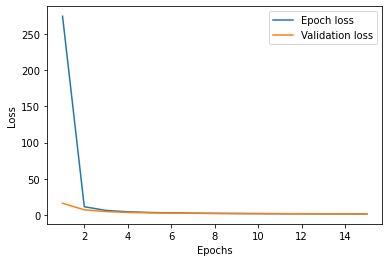

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import sys

D_in = 784   # Input size, images are 28x28 = 784 element vectors
D_out = 10   # Output size, 10 digit classes
H1 = 100     # Hidden layer size
gamma = 1e-5 # Learning rate
epochs = 15

# Define network with one hidden layer, random initial weights
w1 = np.random.randn(D_in, H1)
w2 = np.random.randn(H1, D_out)

bestw1 = 0
bestw2 = 0
bestloss = 10000000

# Create two lists of losses to graph later
losses_epoch_num = []
losses_validation_num = []

def print_array(array):
    list = array.tolist()
    printstr = "\n["
    i = 0
    j = 0
    while i < len(list):
        if type(list[i]) is list:
            printstr += "["
            while j < len(list[i]):
                printstr += str(list[i][j])+", "
                j += 1
            printstr += "],\n"
        else:
            printstr += str(list[i])+", "
        i += 1
    printstr += "]"
    print(printstr)
        

def predict_on_images_numpy(loader, images_to_show):
    global bestw1
    global bestw2
    numberOfCorrect = 0
    for inputs, labels in loader:
        inputs = inputs.numpy()
        labels = labels.numpy()
        for index in range(images_to_show):
            #plot_digit(images[index])
            x = inputs[index].reshape((1, D_in))
            y = np.eye(10)[labels[index]] # 1-hot encoding

            # Forward pass
            h = x.dot(bestw1)
            h_relu = np.maximum(np.zeros((1, H1)), h)
            y_pred = h_relu.dot(bestw2)

            maxindex = np.argmax(y_pred)

            #print(f'Prediction: {guess.item()} - Actual: {labels[index].item()}')
            #print_array(onehot)
            #print_array(y)
            if maxindex == np.argmax(y):
                numberOfCorrect +=1
            #print(f'\nGuess: {maxindex} Actual: {labels[index]} Total: {y_pred.sum()} Argmax_Y: {np.argmax(y)}')
        print(f'\nPercentage correct: {(numberOfCorrect/images_to_show)*100}% ({numberOfCorrect} / {images_to_show})') #Print ratio of correct predictions
        break
        
def predict_on_validation_numpy(loader):
    global bestloss
    global bestw1
    global bestw2
    totalloss = 0
    loop_num = 0
    for inputs, labels in loader:
        inputs = inputs.numpy()
        labels = labels.numpy()
        for i in range(batch_size):
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]]    # 1-hot encoding

            # Forward pass
            h = x.dot(w1)
            h_relu = np.maximum(np.zeros((1, H1)), h)
            y_pred = h_relu.dot(w2)

            # Compute loss function, squared error
            loss = np.square(y_pred - y).sum()        
            totalloss += loss.item()
            loop_num = loop_num + 1
    losses_validation_num.append(totalloss/loop_num)
    if totalloss < bestloss:
        bestloss = totalloss
        bestw1 = w1
        bestw2 = w2
    
# Training iterations
# load a batch
for epoch in range(epochs):
    # Train
    
    batchloss = 0
    loop_num = 0
    for inputs, labels in train_loader:
        inputs = inputs.numpy()
        labels = labels.numpy()
        for i in range(batch_size):
            x = inputs[i].reshape((1, D_in))
            y = np.eye(10)[labels[i]]    # 1-hot encoding

            # Forward pass
            h = x.dot(w1)
            h_relu = np.maximum(np.zeros((1, H1)), h)
            y_pred = h_relu.dot(w2)

            # Compute loss function, squared error
            loss = np.square(y_pred - y).sum()

            # Compute gradients of square-error loss with respect to w1 and w2 using backpropagation
            grad_y_pred = 2 * (y_pred - y)               # L'
            grad_h = np.where(h_relu > 0, 1, 0)          # Derivative of hidden layer
            
            grad_w2 = h_relu.T.dot(grad_y_pred)          # H_relu.T * L'
                                                         # Out from Hidden * L'  
                
            grad_h_relu = grad_y_pred.dot(w2.T)          # L' * W_2.T
            grad_h_w2 = grad_h * grad_h_relu             # F_3' * L' * W_2.T
            grad_w1 = x.T.dot(grad_h_w2)                 # x.T * ( F_3' * L' * W_2.T )

            # Update weights (minibatch stochastic gradient descent)
            w1 -= gamma * grad_w1
            w2 -= gamma * grad_w2
            
            # Store loss to total
            batchloss += loss.item()
            loop_num = loop_num + 1
        print(
            '\rEpoch {} [{}/{}] - Loss: {} ({}/{})'.format(
                epoch+1, loop_num, len(train_loader)*batch_size, batchloss/loop_num, batchloss, loop_num,
            ),
            end=''
        )

    # Validate the model
    losses_epoch_num.append(batchloss/loop_num)
    predict_on_validation_numpy(validation_loader)

# Test the network against 1 validation batch
predict_on_images_numpy(validation_loader, images_to_show = 100)

# Plot training and validation loss
epline, = plt.plot(range(1,epochs+1),losses_epoch_num)
valine, = plt.plot(range(1,epochs+1),losses_validation_num)
epline.set_label('Epoch loss')
plt.legend()
valine.set_label('Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Calculate accuracy on one validation batch

# Optional task
You have now implemented a 2-layer neural network from scratch. Use this new gained knowledge to create an implementation where you can create and train any sized network. This means that you should be able to specify the structure of the network and then train it using back-propagation.